In [ ]:
!pip3 install torch torchvision torchaudio

In [2]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from rsvg import rsvg

In [3]:
from qiskit.visualization import plot_state_city
from rsvg import rsvg
target_state = rsvg(2)
target_op = np.outer(target_state.conj(), target_state)
target_op = torch.tensor(target_op)
print(target_state)
print(target_op)
print('Traço(target_op) = ',np.trace(target_op@target_op))


[-0.62145186-0.40349243j -0.44413952-0.50371771j]
tensor([[0.5490+0.0000j, 0.4793+0.1338j],
        [0.4793-0.1338j, 0.4510+0.0000j]], dtype=torch.complex128)
Traço(target_op) =  (1+0j)


In [ ]:
plot_state_city(target_op.detach().numpy(), title='Matriz Densidade')


In [8]:
device = qml.device('qiskit.aer', wires=3, backend='qasm_simulator')
params = np.random.normal(0,np.pi/2, 3)
params = Variable(torch.tensor(params), requires_grad=True)

@qml.qnode(device, interface="torch")
def circuit(params, M=None):
    qml.Hadamard(wires=0)
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RZ(params[2], wires=0)
    
    return qml.expval(qml.Hermitian(M, wires=[0]))
fig, ax = qml.draw_mpl(circuit, decimals=2)(params)
plt.show()

ValueError: Observable must be a square matrix.

In [52]:
def cost(params):
    L = (1-(circuit(params, M=target_op)))**2
    return L

In [53]:
opt = torch.optim.Adam([params], lr=0.1)
best_loss = 1*cost(params)
best_params = 1*params

In [54]:
fidelity=[]
epochs=[]
for epoch in range(25):
    opt.zero_grad()
    loss = cost(params)
    print(epoch, loss.item())
    loss.backward()
    opt.step()
    if loss < best_loss:
        best_loss = 1*loss
        best_params = 1*params
    f = circuit(best_params, M=target_op).item()
    epochs.append(epoch)
    fidelity.append(f)

0 0.004943847656250016
1 0.001682281494140634
2 0.0005493164062500052
3 0.00038146972656250434
4 0.0002145767211914095
5 6.103515625000173e-05
6 6.103515625000173e-05
7 3.814697265625434e-06
8 4.673004150390777e-05
9 8.5830688476569e-06
10 3.43322753906263e-05
11 0.00011539459228515864
12 6.103515625000173e-05
13 9.536743164062717e-05
14 0.0005493164062500052
15 0.0002145767211914095
16 0.00018692016601562804
17 0.00011539459228515864
18 2.3841857910157334e-05
19 3.43322753906263e-05
20 1.5258789062500867e-05
21 9.536743164062717e-05
22 8.5830688476569e-06
23 1.232595164407831e-32
24 1.5258789062500867e-05


In [55]:
print(circuit(best_params, M=target_op).item())

0.9970703124999999


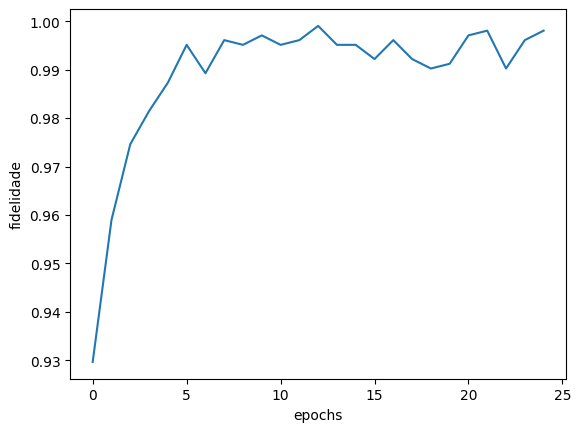

In [56]:
plt.plot(epochs, fidelity)
plt.xlabel('epochs')
plt.ylabel('fidelidade')
plt.show()

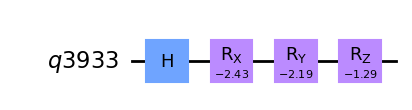

In [61]:
from qiskit import QuantumCircuit
from qiskit import QuantumRegister
qr = QuantumRegister(1)
qc = QuantumCircuit(qr)
qc.h(0)
qc.rx(best_params[0].item(),0)
qc.ry(best_params[1].item(),0)
qc.rz(best_params[2].item(),0)
qc.draw(output='mpl')

In [58]:
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.providers.aer import QasmSimulator
import qiskit
from qiskit import Aer

qstc = state_tomography_circuits(qc, qr[0])
nshots = 8192
job = qiskit.execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots)
qstf = StateTomographyFitter(job.result(), qstc)
rho = qstf.fit(method='lstsq')
print(rho)

[[ 0.90844138+0.j         -0.0664398 -0.28064461j]
 [-0.0664398 +0.28064461j  0.09155862+0.j        ]]


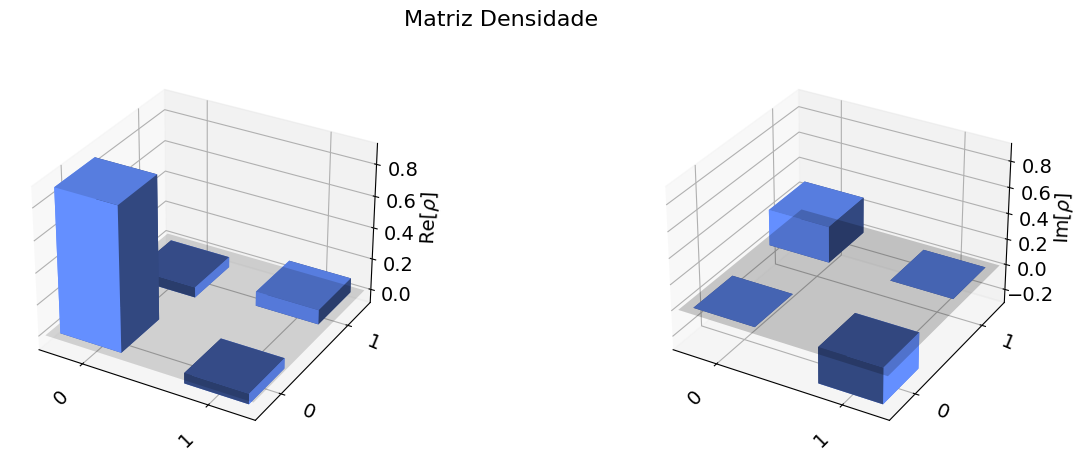

In [60]:
from qiskit.visualization import plot_state_city
plot_state_city(rho, title='Matriz Densidade')

Para estados puros, a fidelidade é igual ao quadrado do valor esperado.

valor esperado pode ser calculado diretamente do VQA.

In [4]:
def fidelidade(target_op):
    return circuit(best_params, M=target_op).item()
def init_state_params():
    params = np.random.normal(0,np.pi/2, 3)
    params = Variable(torch.tensor(params), requires_grad=True)
    target_state = rsvg(2)
    target_op = np.outer(target_state.conj(), target_state)
    target_op = torch.tensor(target_op)
    return target_op, params

@qml.qnode(device, interface="torch")
def circuit(params, M=None):
    qml.Hadamard(wires=0)
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RZ(params[2], wires=0)
    
    return qml.expval(qml.Hermitian(M, wires=[0]))

def cost(params,target_op):
    L = (1-(circuit(params, M=target_op)))**2
    return L

def train(params,target_op):
    opt = torch.optim.Adam([params], lr=0.1)
    best_loss = 1*cost(params,target_op)
    best_params = 1*params
    for epoch in range(30):
        opt.zero_grad()
        loss = cost(params,target_op)
        print(epoch, loss.item())
        loss.backward()
        opt.step()
        if loss < best_loss:
            best_loss = 1*loss
            best_params = 1*params
    return best_params, best_loss


NameError: name 'device' is not defined

In [9]:
def fidelidade(target_op):
    return circuit(best_params, M=target_op).item()
def init_state_params():
    params = np.random.normal(0,np.pi/2, 3)
    params = Variable(torch.tensor(params), requires_grad=True)
    target_state = rsvg(2)
    target_op = np.outer(target_state.conj(), target_state)
    target_op = torch.tensor(target_op)
    return target_op, params

device = qml.device('qiskit.aer', wires=3, backend='qasm_simulator')
@qml.qnode(device, interface="torch")
def circuit(params, M=None):
    qml.Hadamard(wires=0)
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RZ(params[2], wires=0)
    
    return qml.expval(qml.Hermitian(M, wires=[0]))

def cost(params,target_op):
    L = (1-(circuit(params, M=target_op)))**2
    return L

def train(params,target_op):
    opt = torch.optim.Adam([params], lr=0.1)
    best_loss = 1*cost(params,target_op)
    best_params = 1*params
    for epoch in range(30):
        opt.zero_grad()
        loss = cost(params,target_op)
        loss.backward()
        opt.step()
        if loss < best_loss:
            best_loss = 1*loss
            best_params = 1*params
    print(epoch, loss.item())
    return best_params, best_loss


In [14]:
for i in range(10):
    fidelidade_media = 0
    target_op, params = init_state_params()
    best_params, best_loss = train(params,target_op)
    fidelidade_media += fidelidade(target_op)
fidelidade_media = fidelidade_media/10
print(fidelidade_media)

29 0.024109840393066406
29 0.0006446838378906306
29 0.08640384674072266
29 0.0001373291015625
29 3.814697265625e-06
29 0.0013055801391601562
29 0.0006952285766601562
29 0.0005044937133788963
29 1.52587890625e-05
29 0.00024414062500000347
0.09912109374999999


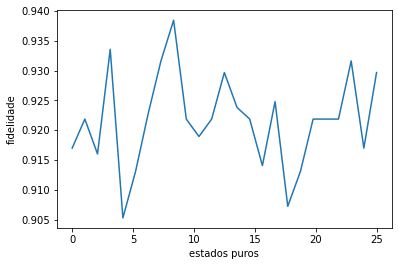

In [112]:
x=np.linspace(0,len(fidelity),len(fidelity))
plt.plot(x, fidelity)
plt.xlabel('estados puros')
plt.ylabel('fidelidade')
plt.show()